# Segment and quantify puncta (Setup)

This is a setup notebook for adjusting parameters for [run_puncta_analysis.ipynb](run_puncta_analysis.ipynb).

Run this notebook cell-by-cell and follow the instructions.

## Documentation

[Details of the puncta segmentation procedure](../docs/puncta_segmentation.md)

[Table summarizing all parameters that are adjusted in this notebook](../docs/parameters.md#list-of-parameters-for-puncta-segmentation-and-analysis)


## Requirements

- A **folder with images** to analyze. All z-layers and channels for a specific sample must be combined into a single file. To combine z-layers and channels, use the [setup_images_to_stack.ipynb](setup_images_to_stack.ipynb) and [run_images_to_stack.ipynb](run_images_to_stack.ipynb) notebooks.

or 

- A  **folder with images** generated by [run_roi_segmentation.ipynb](run_roi_segmentation.ipynb) or [run_roi_segmentation.py](../scripts/run_roi_segmentation.py); the images must contain raw image channels + ROI segmentation mask

<hr style="height:2px;">

## Config

<hr style="height:2px;">

### The following code imports and declares functions used for the processing:

In [39]:
#################################
#  Don't modify the code below  #
#################################

import json
import os
import numpy as np
import intake_io
from skimage.feature import blob_log
from skimage.segmentation import watershed
from scipy import ndimage
import pylab as plt
from skimage import io
from skimage import filters
from skimage import feature
from skimage import restoration
from skimage import morphology as morph
from tqdm import tqdm

from am_utils.utils import walk_dir
from punctatools.lib.segment import calculate_background_image, centers_to_markers, threshold_puncta, filter_laplace
from punctatools.lib.utils import show_dataset, display_blobs
from punctatools.lib.utils import crop_dataset, convert_params

%matplotlib inline

In [2]:
def show_imgs(imgs, s=4):
    fig, ax = plt.subplots(1, len(imgs), figsize=(len(imgs)*s, s))
    for i in range(len(imgs)):
        plt.sca(ax[i])
        io.imshow(imgs[i].max(0))


<hr style="height:2px;">

## Set up the data to segment

<hr style="height:2px;">

`input_dir`: A folder with images to analyze. If ROI segmentation was done, set this to the `output_dir` of the ROI segmentation. 

`roi_segmentation`: Set to `True` if the ROI segmentation was done and the last channel of the images in the `input_dir` contains the segmentation mask

`output_dir`: output directory for the puncta analysis results

In [3]:
input_dir = "/research/sharedresources/cbi/common/Anna/test_data/punctatools/roi"
roi_segmentation = True
output_dir = "../test_output/puncta_analysis"

### The following code lists all image files in the input directory:

In [4]:
#################################
#  Don't modify the code below  #
#################################

print(rf"Input directory: {input_dir}")
if not roi_segmentation:
    print('No cell segmentation provided')
samples = walk_dir(input_dir)

print(f'\n{len(samples)} images were found:')
for i in range(len(samples)):
    print(i, samples[i])

Input directory: /research/sharedresources/cbi/common/Anna/test_data/punctatools/roi

7 images were found:
0 /research/sharedresources/cbi/common/Anna/test_data/punctatools/roi/08102021_GFPempty_-_Position_1_XY1628607860.tif
1 /research/sharedresources/cbi/common/Anna/test_data/punctatools/roi/08102021_MIDI_21FGAA_-_Position_1.tif
2 /research/sharedresources/cbi/common/Anna/test_data/punctatools/roi/08102021_MIDI_21FGAA_-_Position_3.tif
3 /research/sharedresources/cbi/common/Anna/test_data/punctatools/roi/08102021_NHX9_21FGAA_-_Position_2_XY1628613494.tif
4 /research/sharedresources/cbi/common/Anna/test_data/punctatools/roi/08102021_NHX9_-_Position_9_XY1628610088.tif
5 /research/sharedresources/cbi/common/Anna/test_data/punctatools/roi/08102021_NHX9_AAG_-_Position_2_XY1628614911.tif
6 /research/sharedresources/cbi/common/Anna/test_data/punctatools/roi/08102021_Untransfected_-_Position_1_XY1628605933.tif


<hr style="height:0.5px;">

### Please provide the index of the sample to analyze:

Set to `None` to select a random image

In [5]:
# sample_index = 4
sample_index = 5

### The following code loads and displays a random image

<xarray.Dataset>
Dimensions:  (y: 520, x: 559, z: 36, c: 3)
Coordinates:
  * y        (y) float64 0.0 0.11 0.22 0.33 0.44 ... 56.76 56.87 56.98 57.09
  * x        (x) float64 0.0 0.11 0.22 0.33 0.44 ... 61.05 61.16 61.27 61.38
  * z        (z) float64 0.0 0.2 0.4 0.6 0.8 1.0 1.2 ... 6.0 6.2 6.4 6.6 6.8 7.0
Dimensions without coordinates: c
Data variables:
    image    (c, z, y, x) uint16 65 48 47 72 64 70 83 90 81 ... 0 0 0 0 0 0 0 0
Attributes:
    metadata:  {'spacing_units': {'z': 'μm', 'y': 'μm', 'x': 'μm'}} 

Number of channels: 2


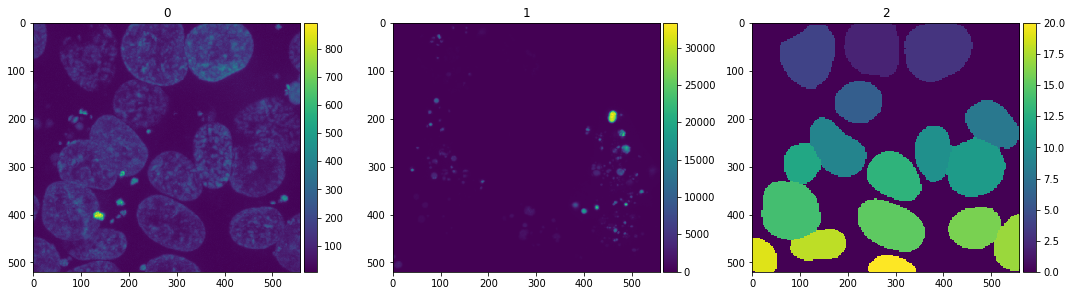

In [6]:
#################################
#  Don't modify the code below  #
#################################

if sample_index is None:
    sample_index = np.random.randint(len(samples))
    
sample = samples[sample_index]
dataset = intake_io.imload(sample)
print(dataset, '\n')
if 'c' in dataset.dims:
    nchannels = len(dataset['c'].data)
else:
    nchannels = 1
if roi_segmentation:
    nchannels -= 1
print(rf"Number of channels: {nchannels}")

show_dataset(dataset)

<hr style="height:0.5px;">

### Please specify the indices of puncta channels and the channel to set up


`puncta_channels` : list of channel indices, starting form 0, that should be used to segment puncta. 

**Examples**:

`puncta_channels = [1]` : puncta will be segmented in the second channel

`puncta_channels = [2, 3]` : puncta will be segmented in the third and fourth channels


In [7]:
puncta_channels = [1]

### The following code displays the puncta channels and the nuclei segmentation of the current image

Current number of z layers: 36


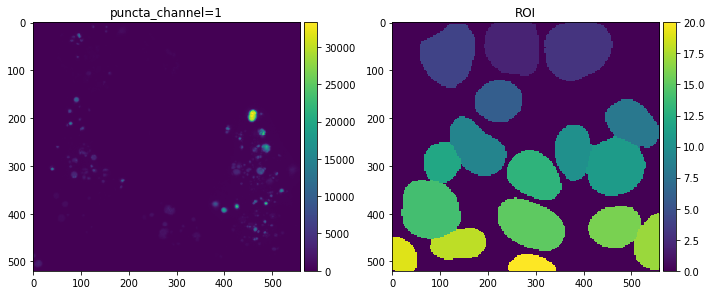

In [8]:
#################################
#  Don't modify the code below  #
#################################

if 'z' in dataset.dims:
    print(rf'Current number of z layers: {len(dataset["z"].data)}')
else:
    print('No z layers were found, the dataset is 2D')
    
channel_names = [rf"puncta_channel={i}" for i in puncta_channels]
    
if roi_segmentation:
    show_dataset(dataset, puncta_channels + [-1], channel_names + ['ROI'])
else:
    show_dataset(dataset, puncta_channels, channel_names)
    

### Please select a small box to test the analysis:

Keep the width and height 200 - 500 pixels.

To used the entire image, set x, y, z, width, height and depth to `None`

In [9]:
x = 350    # coordinate of the left border
y = 150   # coordinate of the top border
z = 10
width = 300   # width of the box
height = 300  # height of the box
depth = 40

### The following code crops the dataset and displays the cropped area:

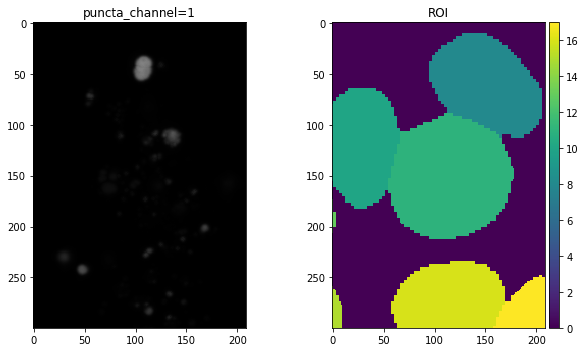

In [10]:
#################################
#  Don't modify the code below  #
#################################

ds_crop = crop_dataset(dataset, x, y, z, width, height, depth)

if roi_segmentation:
    show_dataset(ds_crop, puncta_channels + [-1], channel_names + ['ROI'])
else:
    show_dataset(ds_crop, puncta_channels, channel_names)

In [11]:
spacing = np.array(intake_io.get_spacing(dataset))
if 'c' in ds_crop.dims:
    chnames = ds_crop['c'].data
else:
    chnames = [0]
img = ds_crop.loc[dict(c=chnames[puncta_channels[0]])]['image'].data
roi = ds_crop.loc[dict(c=chnames[-1])]['image'].data

_______________

In [12]:
# frequent:
minsize_um = 0.2  
maxsize_um = 2.5
threshold_detection = 0.001

# advanced:
num_sigma = 5
overlap = 1

In [13]:
logblobs = blob_log(img,
                    min_sigma=minsize_um / spacing,
                    max_sigma=maxsize_um / spacing,
                    num_sigma=int(num_sigma),
                    overlap=overlap,
                    threshold=threshold_detection)

In [14]:
ds_log = ds_crop.copy(deep=True)

In [15]:
log_filt = filter_laplace(img, minsize_um, maxsize_um, int(num_sigma), spacing) 
ds_log['image'].loc[dict(c=chnames[puncta_channels[0]])] = log_filt

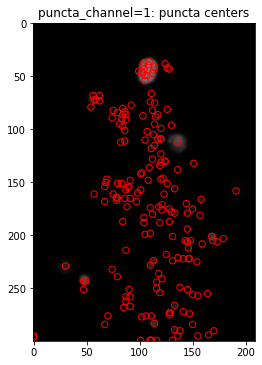

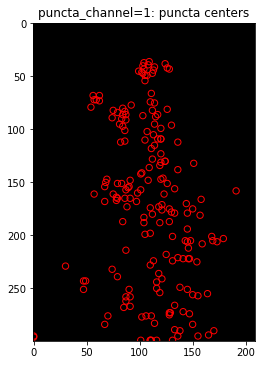

In [16]:
display_blobs(ds_crop, [logblobs[:, :int(logblobs.shape[1]/2)]], 
              puncta_channels, channel_names, 'puncta centers')

display_blobs(ds_log, [logblobs[:, :int(logblobs.shape[1]/2)]], 
              puncta_channels, channel_names, 'puncta centers')

In [17]:
def filter_laplace2(img, minsize_um, maxsize_um, num_sigma, spacing):
    laplace = np.zeros(img.shape, dtype=np.float32)
    for sigma in np.linspace(minsize_um/spacing, maxsize_um/spacing, int(num_sigma), endpoint=True):
        laplace = np.max(np.stack([laplace, -ndimage.gaussian_laplace(img*1., sigma)]), axis=0)

    return laplace

In [56]:
%%time
img = img * 255. / np.max(img)
l = filter_laplace2(img, minsize_um, maxsize_um, int(num_sigma), spacing) * np.mean(minsize_um/spacing) ** 2

CPU times: user 3.73 s, sys: 25 ms, total: 3.75 s
Wall time: 3.76 s


In [57]:
%%time
bg0 = np.array([restoration.rolling_ball(im, radius=maxsize_um/spacing[-1]) for im in tqdm(l)])

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 26/26 [00:00<00:00, 52.07it/s]

CPU times: user 15.7 s, sys: 2.25 ms, total: 15.7 s
Wall time: 505 ms


In [58]:
%%time
bg1 = np.array([morph.opening(im, morph.disk(maxsize_um/spacing[-1])) for im in tqdm(l)])

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 26/26 [00:11<00:00,  2.29it/s]

CPU times: user 11.4 s, sys: 21.3 ms, total: 11.4 s
Wall time: 11.4 s


In [59]:
%%time
bg2 = np.array([morph.opening(im, morph.disk(maxsize_um*2/spacing[-1])) for im in tqdm(l)])

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 26/26 [02:30<00:00,  5.78s/it]

CPU times: user 2min 25s, sys: 4.45 s, total: 2min 30s
Wall time: 2min 30s


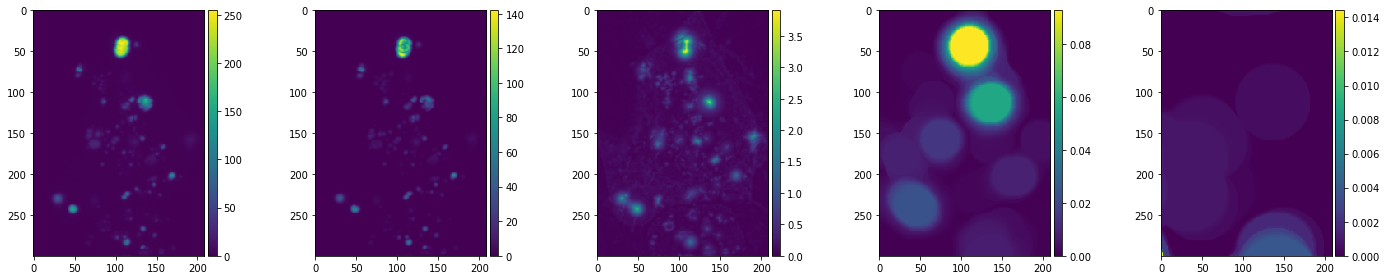

In [60]:
show_imgs([img, l, bg0, bg1, bg2])

In [62]:
mean_bg = ndimage.median(bg2, roi, np.unique(roi)[1:])
thr = np.min(mean_bg[np.where(mean_bg > 0)])
mean_bg, thr

(array([0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
        9.14912827e-05, 0.00000000e+00, 0.00000000e+00]),
 9.149128273182177e-05)

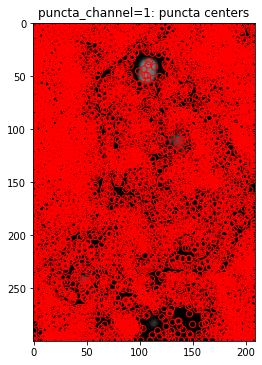

In [63]:
logblobs = blob_log(img,
                    min_sigma=minsize_um / spacing,
                    max_sigma=maxsize_um / spacing,
                    num_sigma=int(num_sigma),
                    overlap=0.8,
                    threshold=thr*10)
display_blobs(ds_crop, [logblobs[:, :int(logblobs.shape[1]/2)]], 
              puncta_channels, channel_names, 'puncta centers')

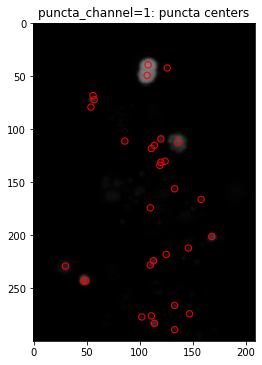

In [37]:
coords = tuple(np.int_(logblobs[:, :3]).transpose())
ind = np.where(l[coords] > bg0[coords]*3)
logblobs_filt = logblobs[ind]
display_blobs(ds_crop, [logblobs_filt[:, :int(logblobs.shape[1]/2)]], 
              puncta_channels, channel_names, 'puncta centers')

In [36]:
l[coords]

array([2284.37408631, 5069.48619502, 8693.51638197, 2827.68055455,
       7960.0314487 , 7920.17377589, 7086.09847329, 6944.15602872,
       5790.78911106, 5520.29306004, 5101.00389434, 5049.74322147,
       4609.25030997, 4024.13886688, 3823.00269875, 3793.65221225,
       3318.17737822, 3158.50880897, 3016.14811864, 2930.2922677 ,
       2839.68832981, 2644.8293529 , 2578.70250074, 2555.35554994,
       2340.97488591, 2335.02201839, 2302.28875978, 2284.3327827 ,
       2262.81415919, 2072.15864462, 2009.98630657])

In [38]:
bg0[coords]

array([22.52577282, 18.49397346,  9.37626818, 21.17125809, 14.22068118,
       13.72558863,  6.11949538,  7.89305157,  4.69387015,  8.34593927,
       12.26344842,  5.30676813,  3.77508482,  1.64341812,  3.16109683,
        3.06693386,  4.43332455,  4.35653363,  4.7816042 ,  4.63503889,
        3.87771629,  2.65891376,  0.76062343,  2.11587271,  3.01613566,
        3.52499407,  4.65268147,  6.8297947 ,  5.75924707,  2.85984402,
        3.53044928])

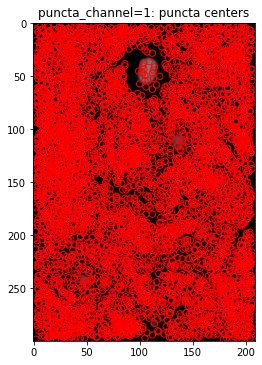

In [46]:
local_maxima = feature.peak_local_max(
    l,
    threshold_abs=thr*100,
    exclude_border=True,
    footprint=np.ones((3,) * (l.ndim)),
)
display_blobs(ds_crop, [local_maxima], 
              puncta_channels, channel_names, 'puncta centers')

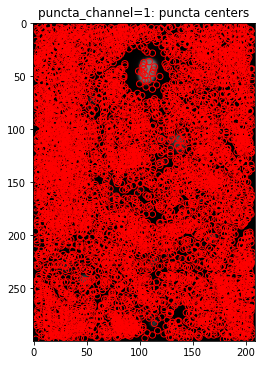

In [47]:
coords = tuple(np.int_(local_maxima).transpose())
ind = np.where(l[coords] > bg0[coords]*3)
logblobs_filt = local_maxima[ind]
display_blobs(ds_crop, [logblobs_filt[:, :int(logblobs.shape[1]/2)]], 
              puncta_channels, channel_names, 'puncta centers')

In [48]:
l[coords]

array([1.85575538e+04, 1.62318946e+04, 1.61991811e+04, ...,
       1.00206483e+00, 1.00096288e+00, 1.00010686e+00])

In [49]:
bg0[coords]

array([11.42896374, 17.88458266, 17.76922475, ...,  0.08817103,
        0.08817103,  0.08817103])